In [1]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import shdom



In [2]:
def calccenterofmass(droplets):
    lwc = droplets.lwc.data
    mx = np.sum(np.sum(lwc,2),1)
    my = np.sum(np.sum(lwc,2),0)
    mz = np.sum(np.sum(lwc,0),0)
    com_x = sum(mx * droplets.grid.x)/sum(mx)
    com_y = sum(my * droplets.grid.y)/sum(my)
    com_z = sum(mz * droplets.grid.z)/sum(mz)
    return com_x, com_y, com_z

def projection_split(projections, n_parts):
    
    avg = len(projections.projection_list) / float(n_parts)
    out = []
    last = 0.0

    while last < len(projections.projection_list):
        out.append(shdom.MultiViewProjection(projections.projection_list[int(last):int(last + avg)]))
        last += avg

    return out

In [3]:
"""
Set settings
"""
#355, 380, 445, 470, 555, 660, 865, 935
wavelengths = [0.66, 0.865]
time_difference = 10 # sec for BOMEX2
n_satellite = 2
num_of_viewed_medium = 7
projection_type = 'perspective'
# projection_type = 'orthographic'

# input_cloud = 'rico52x57x26'
# input_cloud = 'rico32x37x26'
input_cloud = 'BOMEX2'
# input_cloud = 'Linv'


if len(wavelengths) > 1:
    type = 'polychromatic'
else:
    type = 'monochromatic'


output_dir = 'cvpr/{}_lowerres_wl_{}_n_satellite_img_per_sat_{}_projection_{}/dynamic_medium_{}'.format(input_cloud, np.array_str(np.array(wavelengths)).replace(" ", ","),
                                                                                   n_satellite,num_of_viewed_medium, projection_type,type)

# sun
sun_azimuth_list=np.linspace(25,25+0.1*num_of_viewed_medium,num_of_viewed_medium)
sun_zenith_list=np.linspace(121.07,121.07-0.035*(num_of_viewed_medium-1),num_of_viewed_medium)

# solver
iter = 100

In [4]:
# Mie scattering for water droplets
mie_table_paths = [
    '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
    for wavelength in wavelengths
]

solar_spectrum = shdom.SolarSpectrum('../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
solar_fluxes = solar_spectrum.get_monochrome_solar_flux(wavelengths)


In [5]:
# Load a Microphysical scatterer
droplets = shdom.MicrophysicalScatterer()
if input_cloud=='BOMEX2':
    step = int(time_difference/5)
    data_dir = '../synthetic_cloud_fields/WIZ_Clouds/BOMEX2'
    format_ = '*.txt'# load 
    volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
    volumes_paths = [volumes_paths[i] for i in range(100,100+step*num_of_viewed_medium,step)]
    droplets.load_from_csv(volumes_paths[0])
    grid = shdom.Grid(x=droplets.grid.x[357:400],y=droplets.grid.y[340:370],z=np.linspace(0,1.5,45))

elif input_cloud=='Linv':
    step = int(time_difference/30)
    data_dir = '../synthetic_cloud_fields/WIZ_Clouds/Linv'
    format_ = '*.txt'# load 
    volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
    volumes_paths = [volumes_paths[i] for i in range(3,3+step*num_of_viewed_medium,step)]
    droplets.load_from_csv(volumes_paths[0])
    grid = shdom.Grid(x=droplets.grid.x[50:100],y=droplets.grid.y[80:150],z=np.linspace(0,1.5,45))

In [6]:
mie_list = []
for wavelength, table_path in zip(wavelengths, mie_table_paths):  
        # Molecular Rayleigh scattering
        
        mie = shdom.MiePolydisperse()
        mie.read_table(table_path)
        mie_list.append(mie)
droplets.add_mie(mie_list)


Reading mie table from file: ../mie_tables/polydisperse/Water_660nm.scat
Reading mie table from file: ../mie_tables/polydisperse/Water_865nm.scat


In [7]:
# ext = droplets.get_extinction(wavelengths[0])
# e=ext.data
# ee=np.sum(e,2)
# print(ee[ee>0.01].mean()*10/1000)
# import matplotlib.pyplot as plt
# _ = plt.hist(ee[ee>0.01]*10/1000, bins='auto')

In [8]:
droplets.resample(grid)
com_x, com_y, com_z = calccenterofmass(droplets=droplets)
com = np.array([com_x, com_y, com_z])

# time_list = np.arange(0,step*num_of_viewed_medium,step)#sec

Minimum medium effective radius [0.11] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.01]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value


In [9]:
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))


In [10]:
air = shdom.MultispectralScatterer()
mie_list = []
for wavelength, table_path in zip(wavelengths, mie_table_paths):  
        # Molecular Rayleigh scattering
        rayleigh = shdom.Rayleigh(wavelength)
        rayleigh.set_profile(temperature_profile.resample(air_grid))
        air.add_scatterer(rayleigh.get_scatterer())
        mie = shdom.MiePolydisperse()
        mie.read_table(table_path)
        mie_list.append(mie)

Reading mie table from file: ../mie_tables/polydisperse/Water_660nm.scat
Reading mie table from file: ../mie_tables/polydisperse/Water_865nm.scat


In [11]:
temporary_scatterer_list = []
# grid = shdom.Grid(x=np.linspace(com_x-0.5,com_x+0.5,100),y=np.linspace(com_y-0.5,com_y+0.5,100),z=np.linspace(com_z-0.5,com_z+0.5,100))
# grid = shdom.Grid(x=np.linspace(droplets.grid.xmin+0.5,droplets.grid.xmax-0.5,100),y=np.linspace(droplets.grid.ymin+0.5,droplets.grid.ymax-0.5,100),z=np.linspace(droplets.grid.zmin,droplets.grid.zmax-1,100))
time_list = []
for volumes_path in volumes_paths:
    s = volumes_path
    time = int(s[s.rfind('_')+1:s.rfind('.txt')])/2
    time_list.append(time)
    droplets = shdom.MicrophysicalScatterer()
    droplets.load_from_csv(volumes_path)
    for mie in mie_list:  
        droplets.add_mie(mie)
    droplets.resample(grid)

    # pad with zeros
    for data in [droplets.lwc.data, droplets.reff.data, droplets.veff.data]:
        data[0,:,:] = 0
        data[:,0,:] = 0
        data[:,:,0] = 0
        data[-1,:,:] = 0
        data[:,-1,:] = 0
        data[:,:,-1] = 0
        
    temporary_scatterer_list.append(shdom.TemporaryScatterer(droplets,time)) 
# time_list = np.mean(np.split(np.array(time_list),num_of_viewed_medium),1)       


Minimum medium effective radius [0.11] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.01]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value
Minimum medium effective radius [0.11] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.01]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value
Minimum medium effective radius [0.11] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting ex

In [12]:
dynamic_scatterer = shdom.DynamicScatterer()
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    dynamic_scatterer.generate_dynamic_scatterer(scatterer=droplets, time_list=time_list, scatterer_velocity_list=vel_cloud)
else:
    dynamic_scatterer.add_temporary_scatterer(temporary_scatterer_list)

dynamic_medium = shdom.DynamicMedium(dynamic_scatterer,air=air)

In [13]:
scene_params_list = []
numerical_params_list =[]
for sun_azimuth, sun_zenith in zip(sun_azimuth_list, sun_zenith_list):
    scene_params=[]
    numerical_params=[]
    for wavelength, solar_flux in zip(wavelengths, solar_fluxes):
        scene_params.append( shdom.SceneParameters(
            wavelength=wavelength,
            source=shdom.SolarSource(azimuth=sun_azimuth, zenith=sun_zenith, flux=solar_flux)
        ))
        numerical_params.append(shdom.NumericalParameters(num_mu_bins=8,num_phi_bins=16))
    scene_params_list.append(scene_params)
    numerical_params_list.append(numerical_params)

In [14]:
# orbit altitude:
Rsat = 500 # km
from shdom import CloudCT_setup

# -----------------------------------------------
# ---------Calculate camera footprint at nadir --
# -----------------------------------------------
atmospheric_grid = dynamic_medium.medium_list[0].grid
dx = atmospheric_grid.dx
dy = atmospheric_grid.dy

nz = atmospheric_grid.nz
nx = atmospheric_grid.nx
ny = atmospheric_grid.ny

Lx = atmospheric_grid.bounding_box.xmax - atmospheric_grid.bounding_box.xmin
Ly = atmospheric_grid.bounding_box.ymax - atmospheric_grid.bounding_box.ymin
Lz = atmospheric_grid.bounding_box.zmax - atmospheric_grid.bounding_box.zmin
L = max(Lx,Ly)
Lz_droplets = droplets.grid.bounding_box.zmax - droplets.grid.bounding_box.zmin
dz = Lz_droplets/nz

#USED FOV, RESOLUTION and SAT_LOOKATS:
PIXEL_FOOTPRINT = 0.02 # km
PIXEL_FOOTPRINT = 0.01 # km
fov = 2*np.rad2deg(np.arctan(0.5*L/(Rsat)))
cny = int(np.floor(L/PIXEL_FOOTPRINT))
cnx = int(np.floor(L/PIXEL_FOOTPRINT))

CENTER_OF_MEDIUM_BOTTOM = [0.5*nx*dx + atmospheric_grid.bounding_box.xmin, 0.5*ny*dy + atmospheric_grid.bounding_box.ymin , droplets.grid.bounding_box.zmin]

# Somtimes it is more convinent to use wide fov to see the whole cloud
# from all the view points. so the FOV is aslo tuned:
IFTUNE_CAM = True
# --- TUNE FOV, CNY,CNX:
if(IFTUNE_CAM):
    L = 1.5*L
    fov = 2*np.rad2deg(np.arctan(0.5*L/(Rsat)))
    cny = int(np.floor(L/PIXEL_FOOTPRINT))
    cnx = int(np.floor(L/PIXEL_FOOTPRINT))    

print(20*"-")
print(20*"-")
print(20*"-")

print("CAMERA intrinsics summary")
print("fov = {}[deg], cnx = {}[pixels],cny ={}[pixels]".format(fov,cnx,cny))

print(20*"-")
print(20*"-")
print(20*"-")

print("Medium summary")
print("nx = {}, ny = {},nz ={}".format(nx,ny,nz))
print("dx = {}, dy = {},dz ={}".format(dx,dy,dz))
print("Lx = {}, Ly = {},Lz ={}".format(Lx,Ly,Lz))
x_min = atmospheric_grid.bounding_box.xmin
x_max = atmospheric_grid.bounding_box.xmax

y_min = atmospheric_grid.bounding_box.ymin
y_max = atmospheric_grid.bounding_box.ymax

z_min = atmospheric_grid.bounding_box.zmin
z_max = atmospheric_grid.bounding_box.zmax 
print("xmin = {}, ymin = {},zmin ={}".format(x_min,y_min,z_min))
print("xmax = {}, ymax = {},zmax ={}".format(x_max,y_max,z_max))

print(20*"-")
print(20*"-")
print(20*"-")
# ---------------------------------------------------------------
# ---------------CREATE THE SETUP----------------------------
# ---------------------------------------------------------------
SATS_NUMBER = n_satellite*num_of_viewed_medium
VISSETUP = False
# not for all the mediums the CENTER_OF_MEDIUM_BOTTOM is a good place to lookat.
# tuning is applied by the variavle LOOKAT.
LOOKAT = CENTER_OF_MEDIUM_BOTTOM
LOOKAT[2] = 0.5*nz*dz # tuning
# LOOKAT = com
SAT_LOOKATS = np.array(SATS_NUMBER*LOOKAT).reshape(-1,3)       

# create CloudCT setup:
CloudCT_VIEWS = CloudCT_setup.Create(\
    SATS_NUMBER = SATS_NUMBER,ORBIT_ALTITUDE = Rsat, \
    CAM_FOV = fov, CAM_RES = (cnx,cny), SAT_LOOKATS = SAT_LOOKATS, VISSETUP = VISSETUP)

--------------------
--------------------
--------------------
CAMERA intrinsics summary
fov = 0.07219268574935214[deg], cnx = 63[pixels],cny =63[pixels]
--------------------
--------------------
--------------------
Medium summary
nx = 43, ny = 30,nz =63
dx = 0.009999990463256836, dy = 0.009999990463256836,dz =0.023809523809523808
Lx = 0.4200000762939453, Ly = 0.28999996185302734,Lz =20.0
xmin = 3.569999933242798, ymin = 3.4000000953674316,zmin =0.0
xmax = 3.990000009536743, ymax = 3.690000057220459,zmax =20.0
--------------------
--------------------
--------------------


In [15]:
# split_indices = np.cumsum(CloudCT_VIEWS.npix[:-1])
# CloudCT_VIEWS_splited = projection_split(CloudCT_VIEWS, num_of_viewed_medium)
CloudCT_VIEWS_splited = shdom.MultiViewProjection(CloudCT_VIEWS.projection_list)
CloudCT_VIEWS_splited = CloudCT_VIEWS.projection_list
projections_list =[]
for i in range(num_of_viewed_medium):
    projections_list+=[shdom.MultiViewProjection(CloudCT_VIEWS_splited[i::num_of_viewed_medium])]
    projections_list[i]._resolution=CloudCT_VIEWS.resolution[i::num_of_viewed_medium]

CloudCT_VIEWS_splited = projections_list
dynamic_projection = shdom.DynamicProjection(CloudCT_VIEWS_splited)

In [16]:
dynamic_solver = shdom.DynamicRteSolver(scene_params=scene_params_list,numerical_params=numerical_params_list)
dynamic_solver.set_dynamic_medium(dynamic_medium)
dynamic_solver.solve(maxiter=iter,verbose=True)

In [17]:
dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), dynamic_projection)
images = dynamic_camera.render(dynamic_solver,n_jobs=40)

In [18]:
measurements = shdom.DynamicMeasurements(camera=dynamic_camera, images=images, wavelength=wavelengths,time_list=time_list)
measurements.set_noise(shdom.AirMSPINoise())

In [19]:
shdom.save_dynamic_forward_model(output_dir, dynamic_medium, dynamic_solver, measurements)

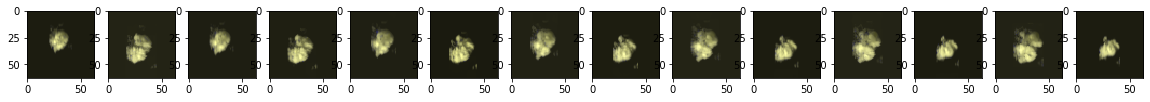

In [20]:
%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr, images):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1)),image),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    # image -= image.min()
    ax.imshow(image/image.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

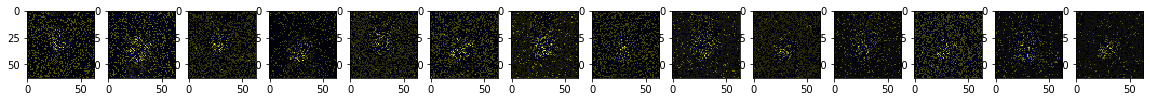

In [21]:
%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image, noisy_image in zip(axarr, images, measurements.images):
    dif_image = noisy_image-image
    if len(dif_image.shape)>2 and dif_image.shape[2]==2:
        dif_image = np.concatenate((np.reshape(dif_image[:,:,0],(dif_image.shape[0],dif_image.shape[1],1)),dif_image),2)
    elif len(dif_image.shape)>2 and dif_image.shape[2]>3:
        dif_image = dif_image[:,:,0:2]
    # image -= image.min()
    ax.imshow(dif_image/dif_image.max())

TypeError: Invalid shape (63, 63, 2) for image data

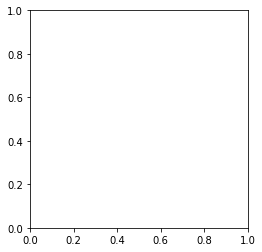

In [22]:
plt.imshow(images[0])
plt.colorbar()

In [ ]:
a,b,c = shdom.load_dynamic_forward_model(output_dir)
print()
  
